In [9]:
from __future__ import print_function
import patsy
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg

import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['font.size'] = 8
pd.set_option('precision', 2)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.figsize'] = (35, 20)
get_ipython().magic('matplotlib inline')
current_palette = sns.color_palette()

In [12]:
url = 'https://raw.githubusercontent.com/cbonilla-catalogue/Statmodel_QuantRegression_Loop/master/HF%20Index%20Performance%20v0.2.csv'
data = pd.read_csv(url, header = 0, index_col='Date')

C:\Users\Carlos Bonilla\Anaconda3\lib\site-packages\numpy\lib\function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Carlos Bonilla\Anaconda3\lib\site-packages\numpy\lib\function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


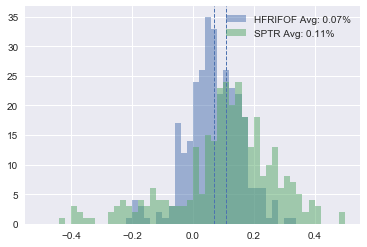

In [21]:
x = data.pct_change(periods = 12).HFRIFOF
y = data.pct_change(periods = 12).SPTR

plt.hist(x, bins = 50, range=[-.5,.5], alpha=0.5, label='HFRIFOF Avg: '+format(x.mean(), '.2f')+'%')
plt.hist(y, bins = 50, range=[-.5,.5], alpha=0.5, label='SPTR Avg: '+format(y.mean(),'.2f')+'%')
#plt.hist(z, bins = 50, range=[-.5,.5], alpha=0.5, label='US10yr Avg: '+format(z.mean(),'.2f')+'%')
plt.axvline(x.mean(), linestyle='dashed', linewidth=1)
plt.axvline(y.mean(), linestyle='dashed', linewidth=1)
#plt.axvline(z.mean(), linestyle='dashed', linewidth=1)

plt.legend(loc='upper right')
plt.show()

C:\Users\Carlos Bonilla\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.bootstrap_plot' is deprecated, import 'pandas.plotting.bootstrap_plot' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


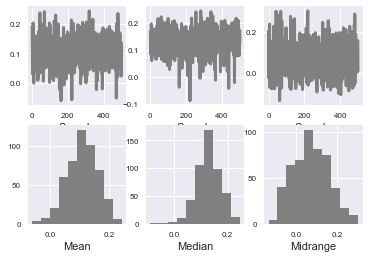

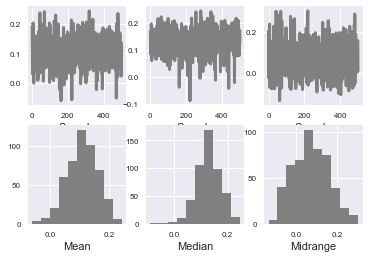

In [14]:
x = data.pct_change(periods = 12).SPTR.dropna()
from pandas.tools.plotting import bootstrap_plot
bootstrap_plot(x, size=10, samples=500, color='grey')


In [15]:
def quantile_model_params(y_var,x_var,training_data,quantile_list = [.05,.95]):
    
    #Package dependencies
    import numpy as np
    import pandas as pd
    import statsmodels.api as sm
    import statsmodels.formula.api as smf
    import patsy #must be version 0.5 or higher
    from statsmodels.regression.quantile_regression import QuantReg

    #Embed function to fit quantile regression using StatsModel in api formula form
    def quantile_model_param(y_var,x_var,training_data,q):
        res = smf.quantreg(y_var+' ~ '+x_var, training_data).fit(q=q)
        return res.params
    
    #Create a dataframe of the required quantiles to later merge with the model params
    quantile_index = pd.DataFrame(quantile_list, columns = ["Quantile"]) 
    
    #Loop through the quantile regression model using the provided quantile index 
    model_temp = pd.DataFrame([quantile_model_param(y_var,x_var,training_data,q = x) 
                               for x in quantile_index["Quantile"]])
    
    #merge the two dtaframes
    models = quantile_index.merge(model_temp,right_index=True,left_index=True)
    models = models.set_index(["Quantile"])
    return models

def quantile_model_predictions(y_var,x_var,quantile_list,training_data):
    
    #Package dependencies
    import numpy as np
    import pandas as pd
    import statsmodels.api as sm
    import statsmodels.formula.api as smf
    import patsy #must be version 0.5 or higher
    from statsmodels.regression.quantile_regression import QuantReg

    #Embed function to fit quantile regression using StatsModel in api formula form
    def quantile_model_prediction(y_var,x_var,training_data,q):
        res = smf.quantreg(y_var+' ~ '+x_var, training_data).fit(q=q)
        return res.predict()
    
    #Create a dataframe of the required quantiles to later merge with the model params
    quantile_index = pd.DataFrame(quantile_list, columns = ["Quantile"]) 
    
    #Loop through the quantile regression model using the provided quantile index 
    model_temp = pd.DataFrame([quantile_model_prediction(y_var,x_var,training_data,q = x) 
                               for x in quantile_index["Quantile"]])
    
    #merge the two dtaframes
    models = quantile_index.merge(model_temp,right_index=True,left_index=True)
    models = models.set_index(["Quantile"]).transpose()
    
    #Return a pandas dataframe ready to plot each quantile prediction as a separate column
    return models

In [16]:
#quantile_model_params use example
quantile_model_params(y_var='HFRIFOF',x_var='USGG10YR+SPTR',quantile_list = np.arange(.05, 1, .15),
                                      training_data = data)


,Intercept,USGG10YR,SPTR
Quantile,,,
0.05,2522.77,-226.21,0.85
0.20,3701.17,-364.63,0.74
0.35,4197.47,-403.90,0.66
0.50,4376.04,-409.31,0.66
0.65,4838.12,-463.33,0.66
0.80,3639.93,-346.21,1.25
0.95,3258.94,-293.50,1.50


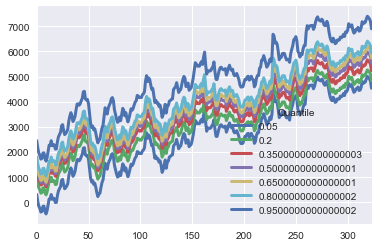

In [17]:
#quantile_model_predictions use example
temp = quantile_model_predictions(y_var='HFRIFOF',x_var='USGG10YR',
                       quantile_list = np.arange(.05, 1, .15),training_data = data)
temp.plot()